## Import Data ##

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import seaborn_image as isns
import pandas as pd
import numpy as np
import random
from scipy.stats import *
import time
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [34]:
image_path = []
labels = []

dir_path = os.getcwd()

for i in os.listdir(f"{dir_path}/Chess"):
    for label in os.listdir(f"{dir_path}/Chess/{i}"):
        for image in os.listdir(f"{dir_path}/Chess/{i}"):
            image_path.append(f"{dir_path}/Chess/{i}/{image}")
            labels.append(i)

df = pd.DataFrame(zip(image_path, labels), columns = ["image_path", "labels"])
df = df.drop_duplicates().reset_index(drop=True)
df

image_path       labels
0    /Users/jay/Jupyter Projects/Chess/Chess/White ...   White king
1    /Users/jay/Jupyter Projects/Chess/Chess/White ...   White king
2    /Users/jay/Jupyter Projects/Chess/Chess/White ...   White king
3    /Users/jay/Jupyter Projects/Chess/Chess/White ...   White king
4    /Users/jay/Jupyter Projects/Chess/Chess/White ...   White king
..                                                 ...          ...
295  /Users/jay/Jupyter Projects/Chess/Chess/White ...  White queen
296  /Users/jay/Jupyter Projects/Chess/Chess/White ...  White queen
297  /Users/jay/Jupyter Projects/Chess/Chess/White ...  White queen
298  /Users/jay/Jupyter Projects/Chess/Chess/White ...  White queen
299  /Users/jay/Jupyter Projects/Chess/Chess/White ...  White queen

[300 rows x 2 columns]

## Statistical Modeling ##

Shape:  (300, 2)

Counts:
 labels
White king      25
Black pawn      25
Black bishop    25
Black knight    25
Black queen     25
Black rook      25
White bishop    25
White pawn      25
Black king      25
White rook      25
White knight    25
White queen     25
Name: count, dtype: int64



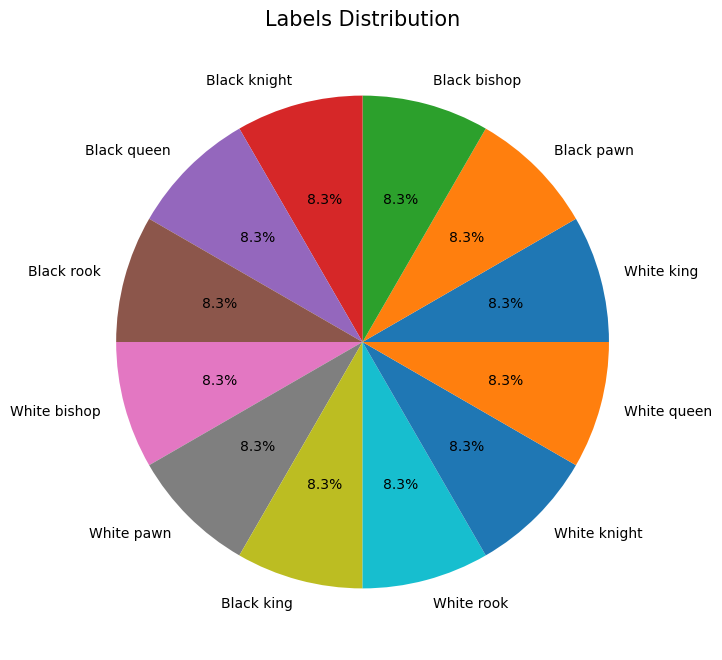

In [38]:
print("Shape: ", df.shape)
print("\nCounts:\n", df["labels"].value_counts())

print()

plt.figure(figsize=(8,8))
plt.pie(df["labels"].value_counts(), labels = df["labels"].value_counts().index, autopct="%1.1f%%")
plt.title("Labels Distribution")
plt.show()

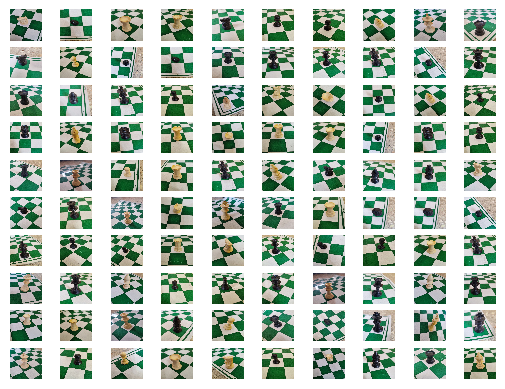

In [40]:
#100 random images
n_rows = 10
n_cols = 10

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis("off")

plt.show()


Description for Image 1:

No. of Obs. : 409600
Min. Value : 0
Max. Value : 232
Mean : 116.96876708984375
Variance : 7867.807717883542
Skewness : -0.242036569463258

Description for Image 2:

No. of Obs. : 409600
Min. Value : 0
Max. Value : 255
Mean : 109.35210693359375
Variance : 7877.502223105321
Skewness : -0.0615265817231951

Description for Image 3:

No. of Obs. : 409600
Min. Value : 0
Max. Value : 255
Mean : 111.322998046875
Variance : 6953.619670356613
Skewness : -0.17914798833049894

Description for Image 4:

No. of Obs. : 409600
Min. Value : 0
Max. Value : 255
Mean : 115.763876953125
Variance : 6331.534132464671
Skewness : -0.37162511864844894

Description for Image 5:

No. of Obs. : 409600
Min. Value : 0
Max. Value : 234
Mean : 118.491279296875
Variance : 6531.0000142814015
Skewness : -0.44566325189269557


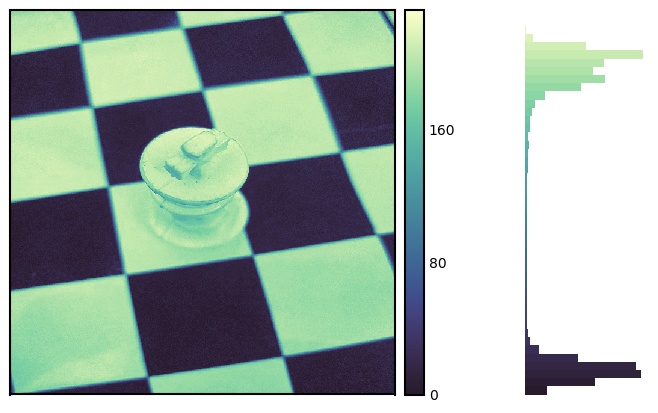

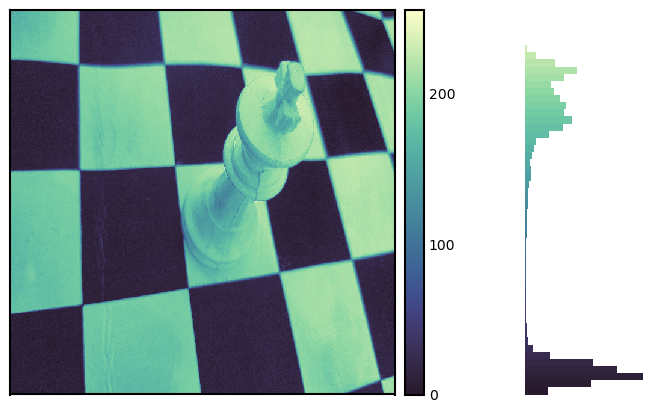

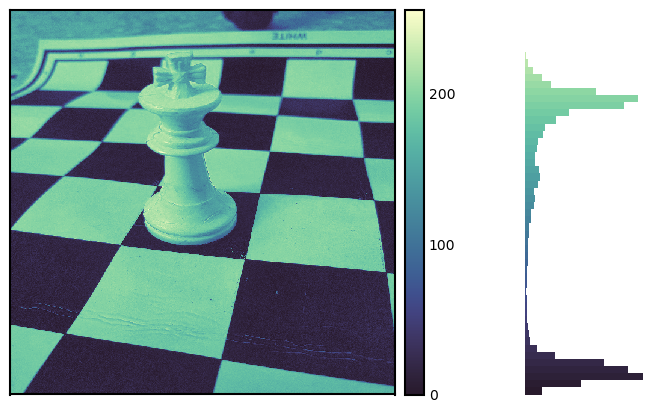

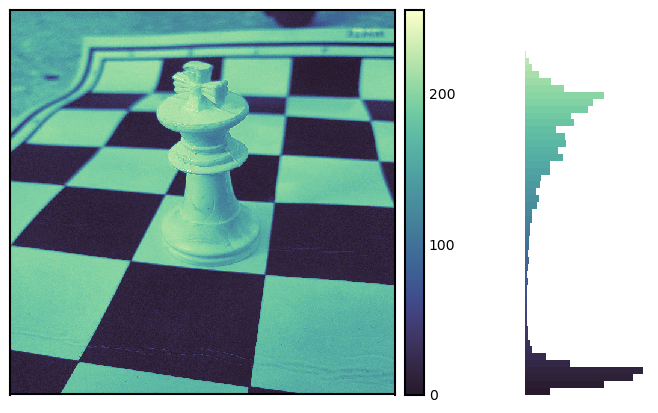

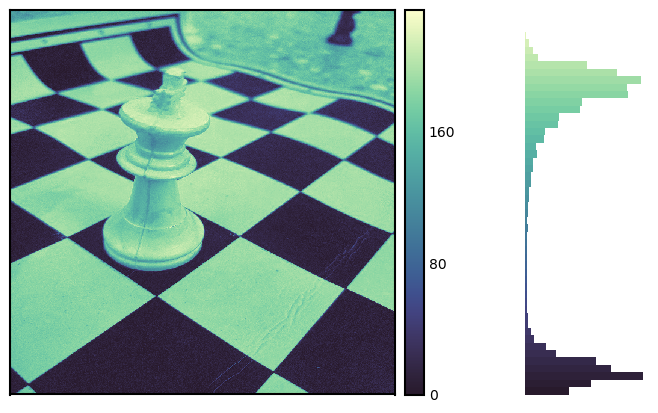

In [42]:
for i in range(5):
    pol = plt.imread(df.iloc[0+i, 0])[:, :, 0]
    print(f"\nDescription for Image {i+1}:\n")
    print("="*50)
    f = isns.imghist(pol, describe=True)

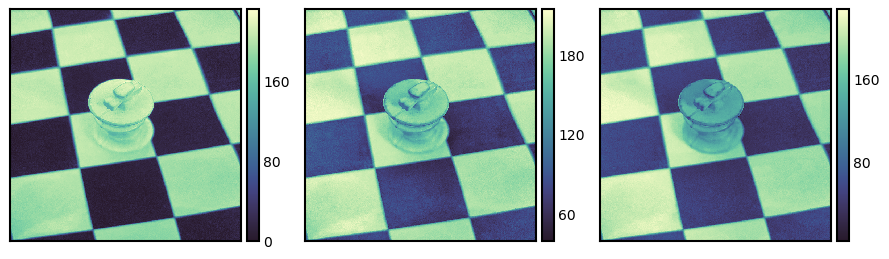

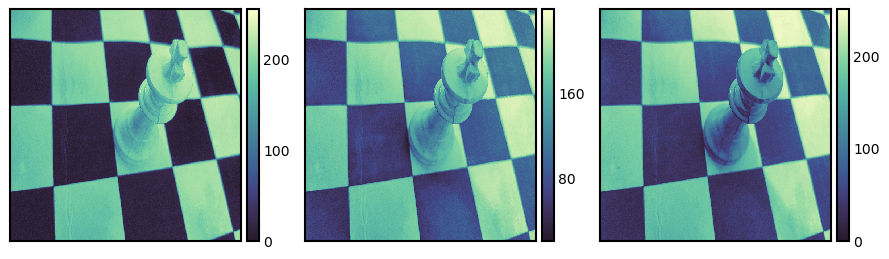

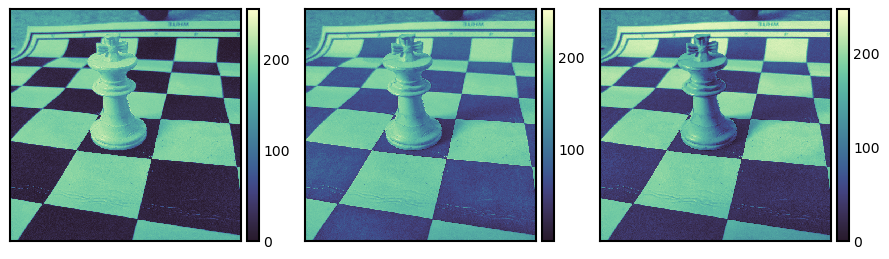

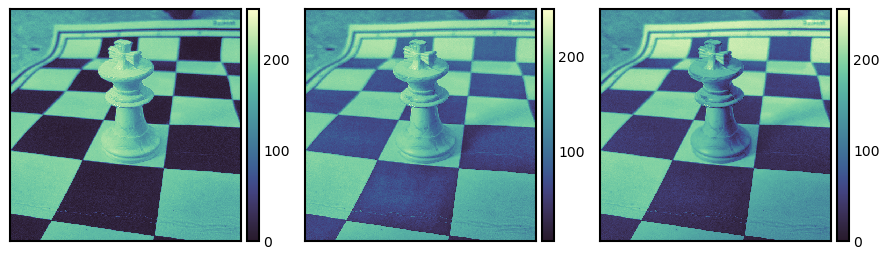

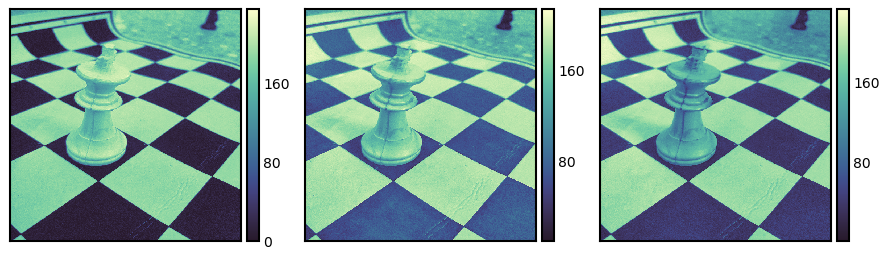

In [44]:
for i in range(5):
    ims = plt.imread(df.iloc[0+i, 0])
    grid = isns.ImageGrid(ims)

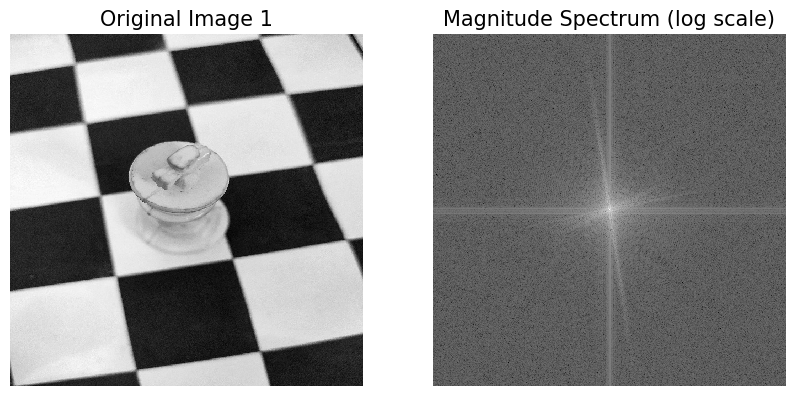

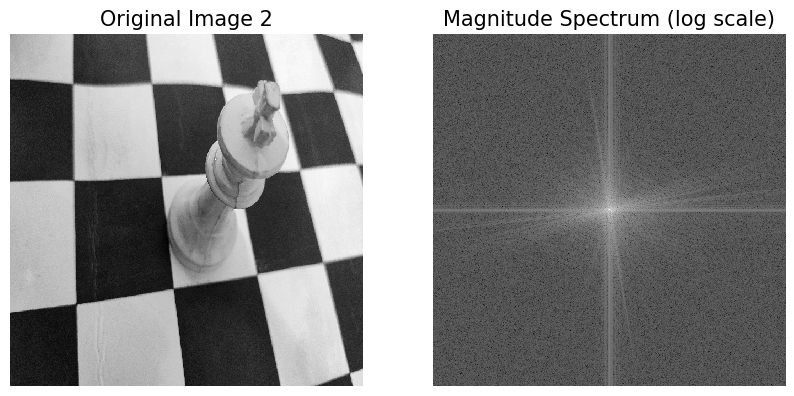

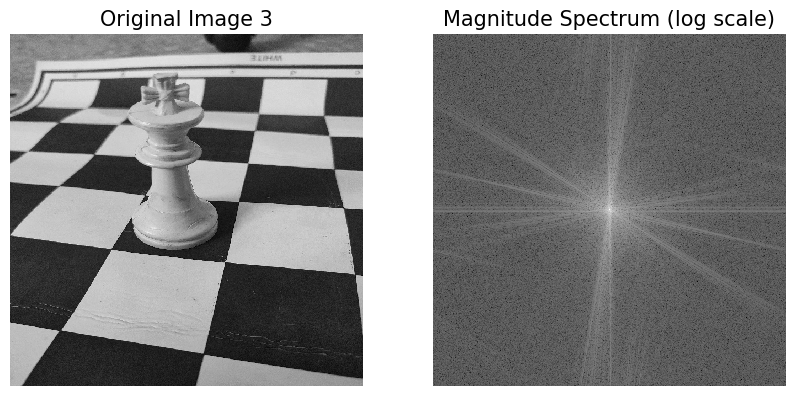

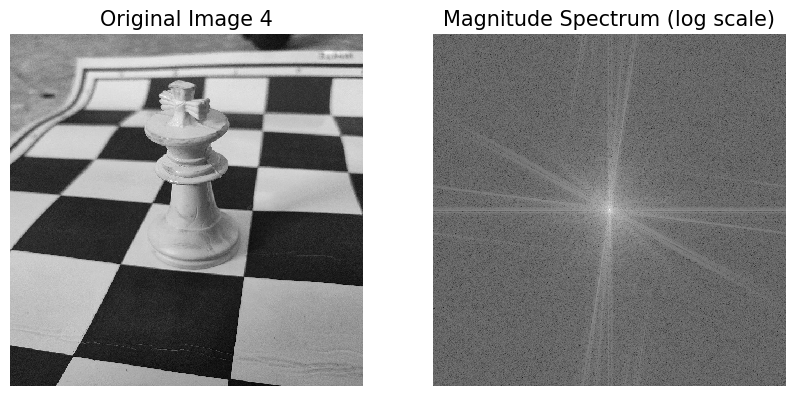

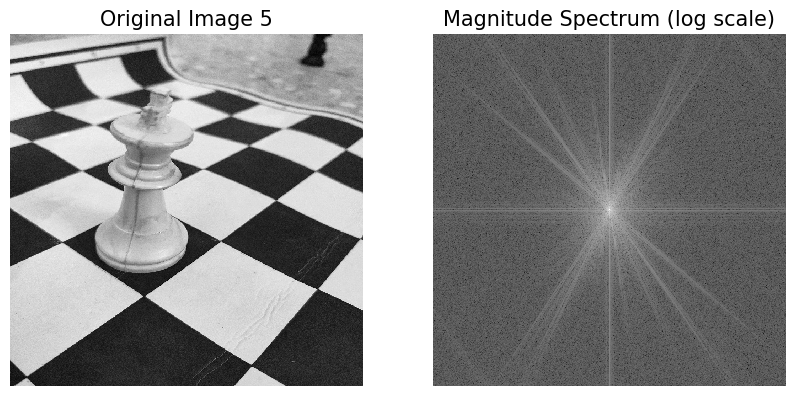

In [46]:
for i in range(5):
    img_data = plt.imread(df.iloc[0+i, 0])
    
    if len(img_data.shape) == 3:
        img_data = np.mean(img_data, axis=2)
    
    ft = np.fft.fft2(img_data)
    
    ft_shifted = np.fft.fftshift(ft)
    
    magnitude_spectrum = np.abs(ft_shifted)
    
    magnitude_spectrum_log = np.log1p(magnitude_spectrum)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_data, cmap="gray")
    plt.title(f"Original Image {i+1}")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum_log, cmap="gray")
    plt.title("Magnitude Spectrum (log scale)")
    plt.axis("off")
    
    plt.show()

Number of clusters in image 1: 3
Number of clusters in image 2: 5
Number of clusters in image 3: 1
Number of clusters in image 4: 3
Number of clusters in image 5: 2


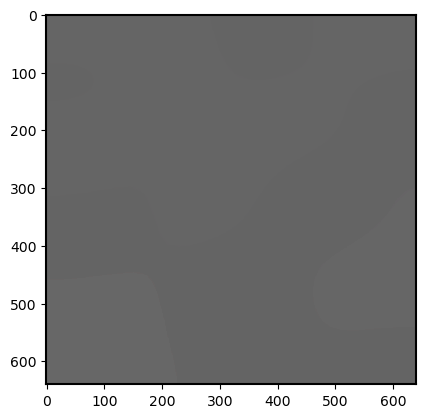

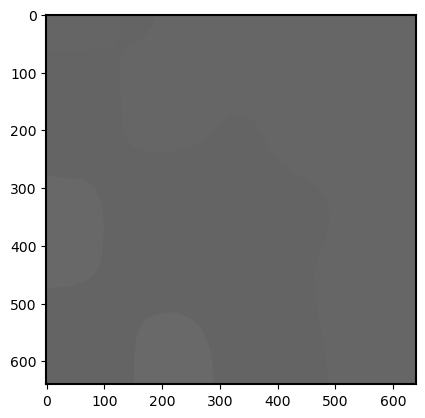

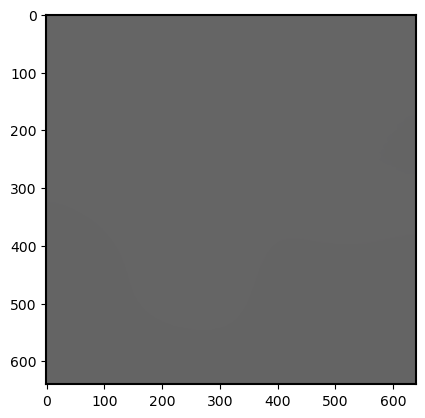

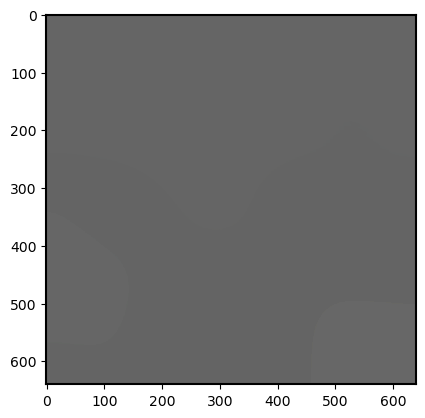

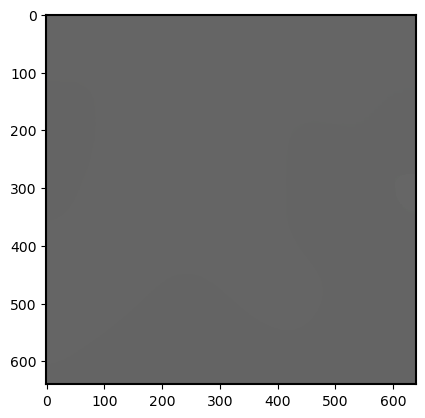

In [91]:
from scipy import ndimage

for i in range(5):
    plt.figure()
    
    im = Image.open(df.iloc[i, 0])
    im2 = ndimage.gaussian_filter(im, sigma=np.std(np.array(im)))
    plt.imshow(im2);
    mask = im2 > im2.mean()
    label_im, nb_labels = ndimage.label(mask)
    print(f"Number of clusters in image {i+1}: {nb_labels}")
    plt.imshow(label_im + 100);
    i += 1

## Training Model ##

In [222]:
train = df.sample(frac = 0.7)
test = df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(210, 2)
(45, 2)
(45, 2)


In [323]:
class NumpyOperations:
    def __init__(self, augment_probability=0.5, apply_linear_ops = False):
        self.augment_probability = augment_probability
        self.apply_linear_ops = apply_linear_ops

    def __call__(self, image):
        image_np = np.array(image)
        
        image_np = image_np / 255
        
        if random.random() < self.augment_probability:
            image_np = np.rot90(image_np)
            
        if random.random() < self.augment_probability:
            image_np = np.rot90(image_np, k=3)
            
        if random.random() < self.augment_probability:
            image_np = np.flip(image_np)
            
        if random.random() < self.augment_probability:
            image_np = np.fliplr(image_np)
                        
        if random.random() < self.augment_probability:
            image_np = np.flipud(image_np)
                        
        if random.random() < self.augment_probability:
            brightness = random.randrange(10, 100)
            image_np = image_np.astype(np.uint16) + brightness
        
        if self.apply_linear_ops:
            image_np = np.transpose(image_np, (1, 0, 2))
        
        image_np = np.clip(image_np, 0, 255)
        image_pil = Image.fromarray((image_np * 255).astype(np.uint8))
        
        return image_pil

In [325]:
le = LabelEncoder()
le.fit(df["labels"])

transform = transforms.Compose([
    transforms.Resize([128, 128]),
    NumpyOperations(),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [350]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, augment_probability=0.5):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.augment_probability = augment_probability
        self.operation_transform = NumpyOperations(augment_probability, apply_linear_ops=False) #Can toggle the linal ops
        self.labels = torch.tensor(le.transform(dataframe["labels"])).to(device)
        self.original_len = len(dataframe)

    def __len__(self):
        return 50 * self.original_len

    def __getitem__(self, idx):
        is_augmented = idx >= self.original_len
        real_idx = idx % self.original_len

        img_path = self.dataframe.iloc[real_idx, 0]
        label = self.labels[real_idx]
        image = Image.open(img_path).convert("RGB")

        if is_augmented:
            image = self.operation_transform(image)

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [352]:
train_dataset = CustomImageDataset(dataframe = train, transform = transform)
val_dataset = CustomImageDataset(dataframe = val, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)

print("New Train Dataset Size:", len(train_dataset))
print("New Validation Dataset Size:", len(val_dataset))
print("New Test Dataset Size:", len(test_dataset))

New Train Dataset Size: 10500
New Validation Dataset Size: 2250
New Test Dataset Size: 2250


In [354]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [356]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [358]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.conv4 = nn.Conv2d(128, 512, kernel_size = 3, padding = 1)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size = 3, padding = 1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear((1024*4*4), 1024)

        self.output = nn.Linear(1024, len(df["labels"].unique()))

    def forward(self, x):
        x = self.conv1(x) #(32, 128, 128)
        x = self.pooling(x) #(32, 64, 64)
        x = self.relu(x)

        x = self.conv2(x) #(64, 64, 64)
        x = self.pooling(x) #(64, 32, 32)
        x = self.relu(x)

        x = self.conv3(x) #(128, 32, 32)
        x = self.pooling(x) #(128, 16, 16)
        x = self.relu(x)

        x = self.conv4(x) #(512, 16, 16)
        x = self.pooling(x) #(512, 8, 8)
        x = self.relu(x)
        
        x = self.conv5(x) #(1024, 8, 8)
        x = self.pooling(x) #(1024, 4, 4) same as number in self.linear
        x = self.relu(x)
        
        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x

In [360]:
model = Net().to(device)

In [362]:
summary(model)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            590,336
├─Conv2d: 1-5                            4,719,616
├─MaxPool2d: 1-6                         --
├─ReLU: 1-7                              --
├─Flatten: 1-8                           --
├─Linear: 1-9                            16,778,240
├─Linear: 1-10                           12,300
Total params: 22,193,740
Trainable params: 22,193,740
Non-trainable params: 0

In [364]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [366]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

start_time = time.time()

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()
        
        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            
            val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
            total_acc_val += val_acc
        
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/val_dataset.__len__()*100, 4))

    print(f'''Epoch no. {epoch+1}/{EPOCHS} 
    Training Loss: {round(total_loss_train/1000, 4)} 
    Training Accuracy: {round(total_acc_train/train_dataset.__len__()*100, 4)} 
    Validation Loss: {round(total_loss_val/1000, 4)} 
    Validation Accuracy: {round(total_acc_val/val_dataset.__len__()*100, 4)}''')

    print("="*50)

print("Training Time is: ", round((time.time() - start_time), 4), " Seconds")

Epoch no. 1/10 
    Training Loss: 1.6067 
    Training Accuracy: 11.1143 
    Validation Loss: 0.3345 
    Validation Accuracy: 5.2444
Epoch no. 2/10 
    Training Loss: 1.4866 
    Training Accuracy: 16.2286 
    Validation Loss: 0.3321 
    Validation Accuracy: 8.4444
Epoch no. 3/10 
    Training Loss: 1.404 
    Training Accuracy: 22.0762 
    Validation Loss: 0.3299 
    Validation Accuracy: 10.9778
Epoch no. 4/10 
    Training Loss: 1.3265 
    Training Accuracy: 26.9905 
    Validation Loss: 0.3212 
    Validation Accuracy: 13.9111
Epoch no. 5/10 
    Training Loss: 1.2616 
    Training Accuracy: 30.8762 
    Validation Loss: 0.3283 
    Validation Accuracy: 14.1333
Epoch no. 6/10 
    Training Loss: 1.2522 
    Training Accuracy: 31.219 
    Validation Loss: 0.334 
    Validation Accuracy: 15.8222
Epoch no. 7/10 
    Training Loss: 1.2394 
    Training Accuracy: 31.6095 
    Validation Loss: 0.3567 
    Validation Accuracy: 16.6667
Epoch no. 8/10 
    Training Loss: 1.2326 
   

In [367]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        predictions = model(inputs)
        
        acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
        total_acc_test += acc
        
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

print(f'''Accuracy Score: {round((total_acc_test/test_dataset.__len__())*100, 4)} 
Loss: {round(total_loss_test/1000, 4)}''')

Accuracy Score: 17.5556 
Loss: 0.4028


## Post-Training Analysis ##

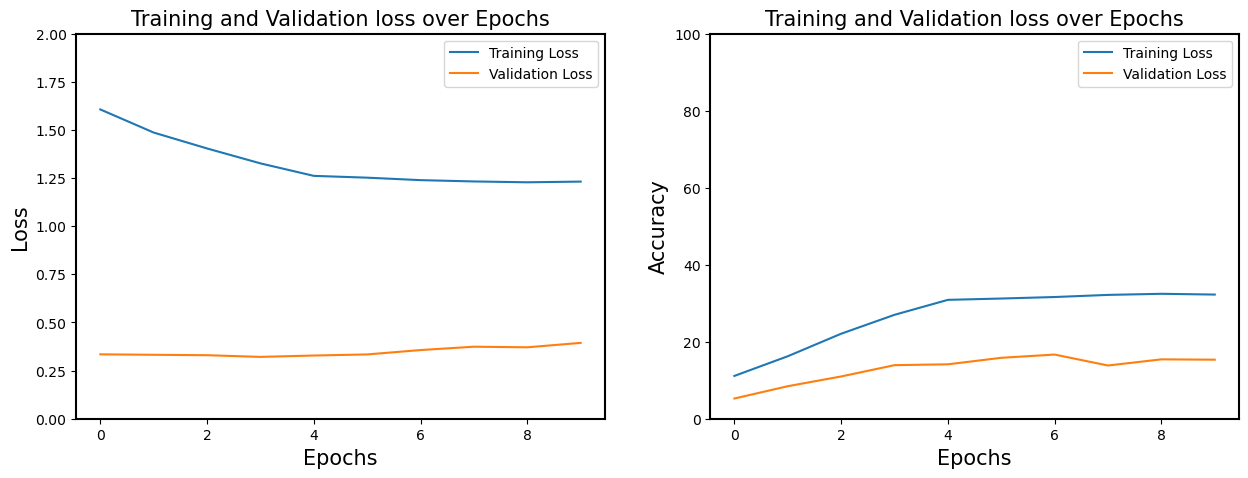

In [381]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Loss")
axs[1].plot(total_acc_validation_plot, label = "Validation Loss")
axs[1].set_title("Training and Validation loss over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [369]:
torch.save(model.state_dict(), "Chess.pth")

In [370]:
loaded_model = Net().to(device)
loaded_model.load_state_dict(torch.load("Chess.pth"))
loaded_model.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=16384, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=12, bias=True)
)

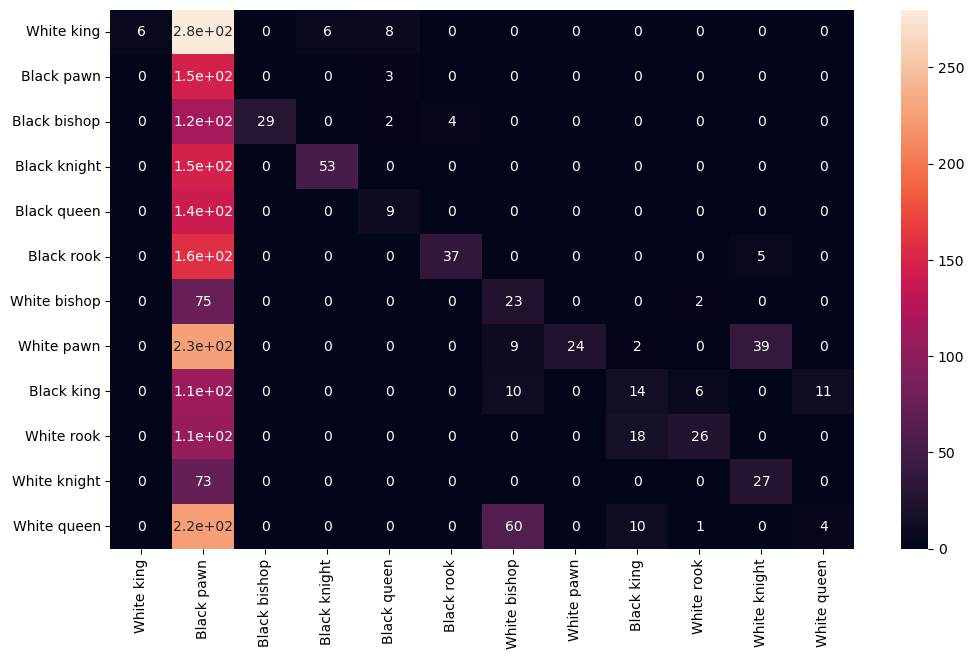

In [371]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

y_pred = []
y_true = []

for inputs, labels in test_loader:
        output = loaded_model(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

classes = df["labels"].unique()

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True);

In [372]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)
    
    model_prediction = loaded_model(image.unsqueeze(0))
    model_prediction = torch.argmax(model_prediction, axis = 1).item()
    
    return le.inverse_transform([model_prediction])

['Black king']


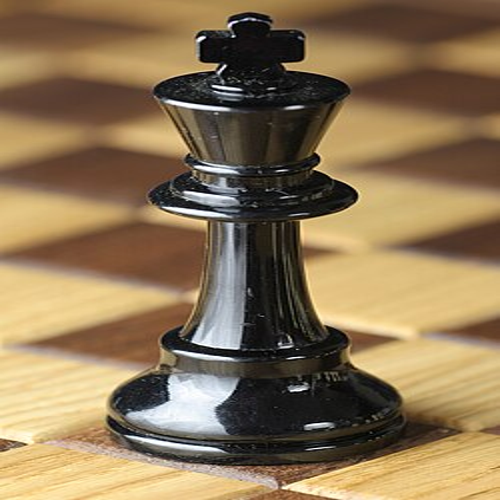

In [419]:
path1 = f"{dir_path}/King.JPG"
print(predict_image(path1))
Image.open(path1).convert("RGB").resize([500, 500])